# Introduction to PyPore

<i>Author: <a href="http://users.soe.ucsc.edu/~jmschrei/">Jacob Schreiber</a> jmschreiber91@gmail.com</i>

<a href="http://github.com/jmschrei/PyPore">PyPore</a> is a Python package for the analysis, visualization, and storage of nanopore data for the UCSC Nanopore Group. It focuses on being extensible through object orientation, and speed optimized by writing computationally intensive code in Cython. Currently the easiest way to get it is to clone from the GitHub repository. It requires numpy and matplotlib.

In [1]:
%matplotlib inline
import numpy as np
import PyPore

print ("numpy version: {}".format( np.__version__ ))
print ("PyPore version: {}".format( PyPore.__version__ ))

numpy version: 1.18.1
PyPore version: 0.2.0


The UCSC Nanopore Group uses biological nanopores, which are single protein porins inserted into lipid bilayers contained in a salt solution. When a voltage is applied, salt molecules pass through the porin, and an ionic current can be sampled at a high frequency. Biomolecules in the solution are also pulled through the porin, and cause the ionic current to fluctuate in a sequence-specific manner. A common computational task is to try to infer properties of the sequence from the ionic current recorded.

However, before we get to that, lets see how we load up some data. Data is stored in axon binary files (abf), which each store 12.5 minutes (750 seconds) of data, with 100,000 samples per second. Loading this data is as simple as casting a filename as a file. These can be absolute or relative pathnames. 

## Files

second:  250000
start:  0
end:  20


(0, 1)

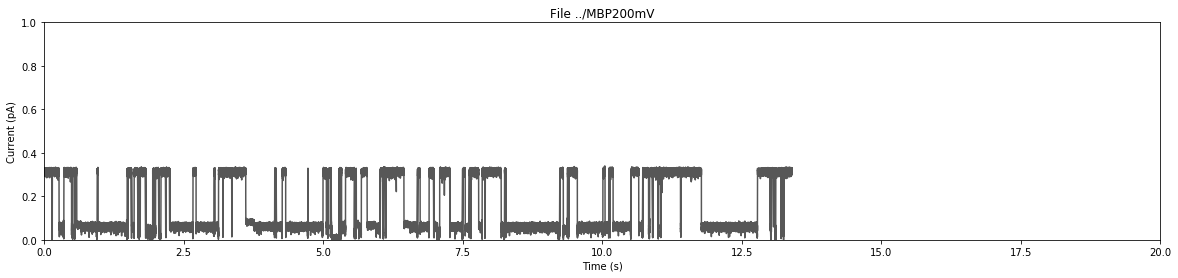

In [6]:
from PyPore.DataTypes import *
import seaborn as sns

file = File( "../MBP200mV.bdat" )

plt.figure( figsize=(20, 4))
file.plot( (0,20), downsample=10, c='k', alpha=0.66 )
plt.ylim(0, 1)

Open channel current is ~110 pA, and corresponds to nothing but ions passing through the nanopore. Here we've plotting the first 10 seconds of a file, without analyzing it at all. We see that the file begins at open channel current, has a few transient blockades, then a longer blockage which appears to be structured in some manner, before returning briefly to open channel current.

When an experiment is run, a mixture of <i>enzyme-bound</i> and <i>enzyme-free</i> DNA strands pass through the pore. Enzyme bound strands have a processive enzyme bound to the strand, which regulates the movement of the strand through the nanopore, slowing it down long enough for data to be recorded, and look like the event which goes from ~1.75 seconds to ~5 seconds. Enzyme free strands pass too quickly through the nanopore to have any meaningful data collected, shown by the transient blockades from the start to ~1.75 seconds. 

These transient blockades are meaningless to us. We are only interested in the enzyme-bound translocations. Fortunately, PyPore has a simple event detector which can pull these out by setting an ionic current threshold, and a duration threshold. By default, events are regions of ionic current below 90 pA which are longer than 1 second, and never go below -0.5 pA.

(0, 0.5)

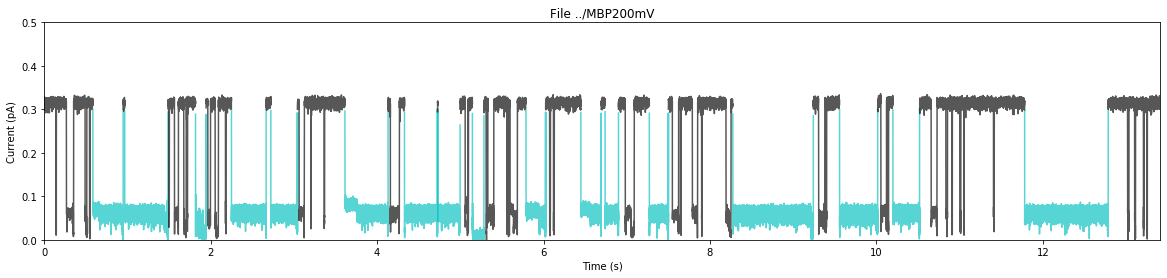

In [15]:
from PyPore.parsers import *

file.parse( lambda_event_parser(threshold=0.3 , rules=[lambda event: event.duration > 30000,
                                lambda event: event.min > -0.5,
                                lambda event: event.max < 0.3 ]))


plt.figure( figsize=(20, 4))
file.plot( )
plt.ylim(0, 0.5)

The one event shown is shown in cyan, while the rest is shown in grey. Lets take a look at the entire file. We need to downsample what we plot, to as the file is huge. We can pass in separate parameters for event handling and file handling. See below. The parameters shown are default, and shown only to display how you could modify the plot to your liking.

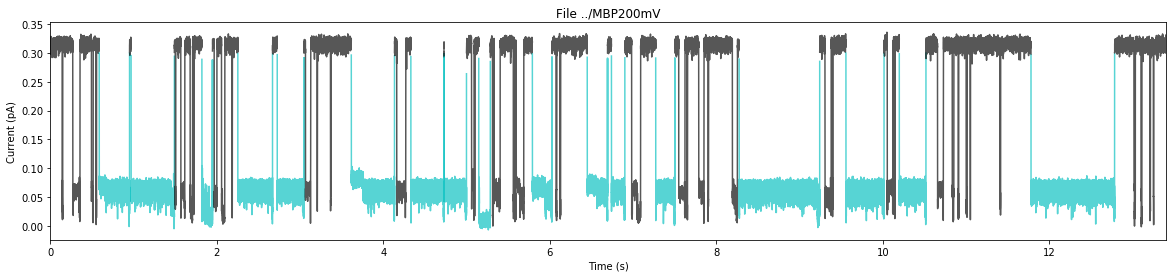

In [16]:
plt.figure( figsize=(20, 4))
file.plot( event_downsample=5, file_downsample=100, downsample=10, file_kwargs={ 'c':'k', 'alpha':0.66 }, 
        event_kwargs={ 'c': 'c', 'alpha':0.66 } )

There are many regions which would be considered events, except that they passed below 0. The phenomena which look like vertical lines correspond to the user reversing the applied voltage temporarily in order to clear a blockage of the pore. Often times strands will get stuck, and must be ejected as they are not completing in a normal manner. These should not be included in a list of events from the file. However, we can show what would be considered an event should we set the minimum current filter to something which is never used. 

Lets look at a file stats of the file before moving on.

In [18]:
print ("File has {} events, and has average ionic current {} (+/- {})".format( file.n, file.mean, file.std ))

File has 17 events, and has average ionic current 0.16252306801750843 (+/- 0.12596889367459427)


## Events

Now lets look at single events.

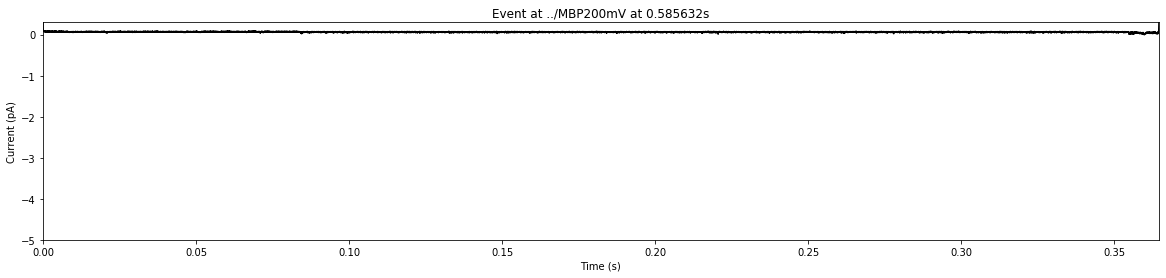

In [19]:
event = file.events[0]

plt.figure( figsize=(20,4) )
event.plot()

Commonly, we want to apply a low-pass filter to the data, and then find a way to segment the event into the discrete segments we see. We expect that the segments contain sequence information, and so we want to be able to isolate them. In order to do that, we want to see these segments. In order to do segmentation, we have a recursive divide and conquer algorithm, which is described in a recent pending publication and can handle arbitrarily filtered data. A Cython implementation of this algorithm is SpeedyStatSplit. We then want to plot the segmentation using a four color cycle, which goes red-blue-orange-green.

Feel free to play around with the parameters to see how it effects the segmentation, if you're reading this using IPython notebook.

In [ ]:
event.filter()
event.parse( SpeedyStatSplit( prior_segments_per_second=10., cutoff_freq=2000., min_width=100 ) )

plt.figure( figsize=(20,4))
event.plot( color='cycle' )

It may look like some areas are oversegmented, but when you zoom in on those areas, they do appear to be different segments. Whether or not this fluctuation is due to a new sequence being read by the nanopore, or some other slight difference in ion passage is debatable. However, it is not the job of the segmenter to determine what the underlying biochemical phenomena is, simply whether or not a region of ionic current is different.

Lets look more at the segmenter. Lets try to relate the parameter "prior_segments_per_second", to the observed number of segments per second.

In [ ]:
prior_segments_range = 10 ** np.arange( -1, 5.5, 0.5 )
n_segments = np.zeros( ( len( prior_segments_range ), file.n ) )

for j, event in enumerate( file.events[1:] ):
    event.filter( order=1, cutoff=2000 )

    for i, prior in enumerate( prior_segments_range ):
        event.parse( SpeedyStatSplit( prior_segments_per_second=prior, cutoff_freq=2000. ) )
        n_segments[i, j] = 1. * event.n / event.duration

plt.figure( figsize=(10,5) )
plt.plot( prior_segments_range, n_segments, c='c', alpha=0.66 )
plt.xscale( 'log' )
plt.yscale( 'log' )
plt.xlabel( 'Prior Segments Per Second' )
plt.ylabel( 'Observed Segments Per Second' )

It is extremely easy to go through all the events and collect some data. In this case, we segment the event using a wide variety segmenter parameters, and then collect the number of segments present.

The number of segments doesn't seem to change that much at low priors, but then will begin to grow as the prior approaches the sampling frequency. The default minimum width of a segment is 100 samples in order to remove edge effects, and so we see the observed number of segments approach $\frac{sampling\ frequency}{min\ width}$. This is to be expected, as it will begin to call every region of length equal to minimum width as its own segment, regardless of the scoring function.

A takeaway is that while getting the order of magnitude correct with the prior, one need not worry about getting it too precise.

Now, there was a cutoff freq parameter, which indicates the frequency with which the data was filtered. What happens if we filter the event, but don't mention that to the segmenter? As a note, we've currently already filtered the event object to 2kHz above, and so we shouldn't do it again. A comment is left in for what code should be run if the event had not been previously filtered.

In [ ]:
event = file.events[0]
#event.filter( order=1, cutoff=2000 )
event.parse( SpeedyStatSplit( prior_segments_per_second=10. ) )
event.plot( color='cycle' ) 

We get drastic oversegmentation if we do this. It's completely unusable. This is because filtering the samples makes them no longer <i>i.i.d.</i>, by replacing each sample with a sample influenced by the original samples neighbors. The scoring function of the segmenter assumes originally that each sample is independent of each other sample, and so needs to make a correction if filtering is used on the data.

## Segments

When an event is segmented, it now is represented into a list of segments. A segment is just a container for an array of ionic current and some metadata about that current. It does not have any analysis methods. If we resegment the event taking cutoff frequency into account, and then plot the second segment (the first segment is often the downspike from open channel), we get the following.

In [ ]:
event.parse( SpeedyStatSplit( prior_segments_per_second=10., cutoff_freq=2000. ))
segment = event.segments[1]
plt.plot( segment.current )
plt.show()

Its representation is a JSON of the metadata.

In [ ]:
segment

Segments themselves aren't terribly interesting, but we often want their metadata. Downstream analyses, such as hidden Markov models, require tuples of properties from these segments, most often just their mean, but sometimes their standard deviation and duration as well. For this purpose, it is useful to understand segments. We can see how we might display the mean of every segment in an event. 

In [ ]:
print ' '.join( str( round( segment.mean, 2 ) ) for segment in event.segments )

## Experiments

A common operation is to have a large set of files, and want to go through each of them and apply the same event detector and segmenter, and end up with events reduced to their metadata. The Experiment object allows you to go through and do this easily, in a memory-efficient manner. The parameters passed in are the default ones. If None is passed in as the segmenter, the event is not segmented, and if None is passed in for the filter_params, the event is not filtered. Verbose gives a summary of what is happening, and meta=True stores only the metadata, not the full ionic current array. The full verbose log is a bit much, but included just to show the summary given.

In [ ]:
exp = Experiment( [ '14418004-s04.abf', '14418005-s04.abf' ] )
exp.parse( event_detector=lambda_event_parser( threshold=90 ), 
           segmenter=SpeedyStatSplit( prior_segments_per_second=10, cutoff_freq=2000. ),
           filter_params=(1,2000),
           verbose=True, 
           meta=False )

## Hidden Markov Models

Given that events are sequencial, hidden Markov models (HMMs) are an obvious way to try to analyze this data. PyPore does not allow you to build HMMs, but support for <a href="http://www.github.com/jmschrei/yahmm">YAHMM</a> is built-in. YAHMM is a general HMM package for Python which is implemented in Cython for speed. The gist is that a model object represents a HMM, and has methods such as model.viterbi, model.forward, model.train, which allow for common HMM operations to be done. Potentially, someone can make their own HMMs as long as they follow the same format.

However, PyPore has some meta-operations, which allow you to build complicated models from individual units. See more <a href="http://nbviewer.ipython.org/github/jmschrei/yahmm/blob/master/examples/ProfileHMM.ipynb">here</a>. Lets quickly build a reference profile from hand-curated data, and see how well it works on this data. We can use the PyPore helper function ModularProfileModel to quickly build a HMM from a reference.

In [ ]:
from PyPore.hmm import *
from epigenetics import *

model = ModularProfileModel( Phi29GlobalAlignmentModule, build_profile(), "Epigenetics-54", insert=UniformDistribution(0,90) )

There are three ways to apply HMMs to nanopore data. A common task is to get the Viterbi path of the sequence through the model. This can be done two ways, if you just want to use the mean. 

In [ ]:
# Way 1
logp, path = event.apply_hmm( model, algorithm='viterbi' )
print "logp: {}".format( logp )
print ", ".join( state.name for idx, state in path )

In [ ]:
# Way 2
logp, path = model.viterbi( [ segment.mean for segment in event.segments ] )
print "logp: {}".format( logp )
print ", ".join( state.name for idx, state in path )

If you're interested in using more than just the mean, you have to use the second way, and that would be something like `logp, path = model.viterbi( [ (s.mean, s.std, s.duration) for s in event.segments ] )`, using whichever properties you want to.

Another common thing is to calculate the sum-of-all-paths log probability of the sequence given the model.

In [ ]:
print event.apply_hmm( model, algorithm='log_probability' )

We can now replicate the analysis done in the profile HMM paper. Again, <a href="http://nbviewer.ipython.org/github/jmschrei/yahmm/blob/master/examples/ProfileHMM.ipynb">see this notebook</a> for more background on what is going on.

Now lets pull the data and reduce it down to the events as a list of means. Lets use the Experiment object described before. Since we're using a lot of data, lets not see the actual log (though you may want to do this in a Pythons script). Lets also turn meta on, since we only care about the means, and the files are gigabytes in size. We'll also import some helper functions from another script, found <a href=https://github.com/UCSCNanopore/Data/blob/master/Automation/epigenetics.py>here</a>. This shows how simple it is to run complicated HMMs through nanopore data.

In [ ]:
from epigenetics import *

files = [ '14418004-s04.abf', '14418005-s04.abf', '14418006-s04.abf',
          '14418007-s04.abf', '14418008-s04.abf', '14418009-s04.abf', 
          '14418010-s04.abf', '14418011-s04.abf', '14418012-s04.abf', 
          '14418013-s04.abf', '14418014-s04.abf', '14418015-s04.abf', 
          '14418016-s04.abf' ]

model = EpigeneticsModel( build_profile(), "Epigenetics-54" )

exp = Experiment( files )
exp.parse( meta=True, verbose=False )

We can confirm the number of files which were analyzed with `exp.n`, and access the files of metadata using `exp.files`.

In [ ]:
exp.n

Lets reduce the data down to the list of means, to run through the classification function.

In [ ]:
events = reduce( list.__add__, [ [ [ segment.mean for segment in event.segments ] for event in file.events ] for file in exp.files ] )

We should now tain on 70 percent of the data, and test on the remaining 30 percent. However, we don't want to train on the complete crap. We will run the classification function on all the events using the untrained model, and only use events which have a filter score of at least 0.1 for Baum-Welch training.

In [ ]:
training_events, testing_events = events[ : int(len(events)*.7) ], events[ int(len(events)*.7) : ]

print "Training Events: {}, Testing Events: {}".format( len(training_events), len(testing_events))

training_data = analyze_events( training_events, model )
training_events = [ event for score, event in zip( training_data['Filter Score'], training_events ) if score > 0.1 ]

model.train( training_events, max_iterations=10, use_pseudocount=True )

Now lets classify the training data using the trained model. 

In [ ]:
testing_data = analyze_events( testing_events, model )

We can now show how the filter score relates to the mean cumulative soft call (MCSC), where MCSC says 'what is the accuracy if I use events this good or better?'

In [ ]:
testing_data = testing_data.sort( 'Filter Score' )[::-1]
testing_data['MCSC'] = [ sum( testing_data['Soft Call'][:i] ) / i for i in xrange( 1, len(testing_data['Soft Call'])+1 ) ]

plt.plot( testing_data['Filter Score'], testing_data['MCSC'] )
plt.ylabel( 'MCSC' )
plt.xlabel( 'Filter Score' )

A repository of IPython notebooks for the UCSC nanopore lab can be found <a href=https://github.com/UCSCNanopore/IPythonNotebooks>here</a>, and involve using PyPore and YAHMM in various ways to solve computational tasks. 

We've seen how to use PyPore to analyze nanopore data extracted from .abf files. This includes pulling the raw data, detecting events, segmenting them, and using a profile HMM in order to extract the useful segments from the data. This pipeline is entirely automated, except for the profile construction.

## Package Information

PyPore is freely available under the MIT license at https://github.com/jmschrei/PyPore. Feel free to contribute or comment!
    
Installing PyPore is as easy as `pip install pythonic-porin`. Dependencies are numpy, Cython, matplotlib, and optional dependencies are PyQt4 and MySQLdb. A good way to get these dependencies is the Anaconda Scientific Python Distribution, or the unofficial list of windows binaries.

If you have questions or comments, my email is jmschreiber91@gmail.com.